In [132]:
# from kerasbeats import prep_multiple_time_series,prep_time_series,NBeatsModel
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.svm import SVR

import numpy as np 
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Flatten
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam, RMSprop
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops

import math
from sklearn.metrics import mean_squared_error
from utils import eval_model
from scipy.stats import pearsonr

# test gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
data_dir = '/home/yicheng.wang/UCL-Dissertation/data/'
output_model_dir = '/home/yicheng.wang/UCL-Dissertation/models/'

df_aluminium = pd.read_csv('dataset/' + '2005-2022-aluminium.csv')
df_copper = pd.read_csv('dataset/' + '2005-2022-copper.csv')
df_iron = pd.read_csv('dataset/' + '2010-2022-iron.csv')
df_palladium = pd.read_csv('dataset/' + '2005-2022-palladium.csv')
df_zinc = pd.read_csv('dataset/' + '2005-2022-zinc.csv')
df_lead = pd.read_csv('dataset/' + '2005-2022-lead.csv')
df_nickel = pd.read_csv('dataset/' + '2005-2022-nickel.csv')
df_platinum = pd.read_csv('dataset/' + '2005-2022-platinum_nymex.csv')
df_rhodium = pd.read_csv('dataset/' + '2005-2022-rhodium.csv')
df_tin = pd.read_csv('dataset/' + '2005-2022-tin.csv')

In [11]:
dataset_all = [df_aluminium, df_copper, df_palladium, df_zinc, df_lead, df_nickel, df_platinum, df_rhodium, df_tin]

common_cols = set.intersection(*map(set,dataset_all))

len(common_cols)

14

In [12]:
for df in dataset_all:
    df.drop(df.columns.difference(common_cols), axis=1, inplace=True)    
    
    if df.columns[0] != 'date' or df.columns[-1] !='y':
        print('something wrong')
print('data cleaned')

data cleaned


In [365]:
def make_dataset(df):

    lookback = 66
    test_start_index = df[df.date >= '2018-05-01'].index[0] - lookback - 22
    val_start_index = df[df.date >= '2016-05-01'].index[0] - lookback

    train_df = df[df.date < '2016-05-01']
    val_df = df.iloc[val_start_index:df[df.date >= '2018-05-01'].index[0]-22]
    test_df = df.iloc[test_start_index:]

    training_set = train_df.loc[:, (train_df.columns != 'date')].values
    val_set = val_df.loc[:, (val_df.columns != 'date')].values
    test_set = test_df.loc[:, (test_df.columns != 'date')].values

    y_date = df[df.date >= '2018-05-01']['date'].values

    X_train = []   # feature
    y_train = []   # label
    X_val = []
    y_val = []
    X_test = [] # feature 
    y_test = [] # label

    # prepare the training dataset
    for i in range(lookback, len(training_set)-22):
        # add to X_train and y_train
        X_train.append(training_set[i-lookback:i,:])
        y_train.append(training_set[i+22,-1])

    # prepare the test dataset    
    for i in range(lookback, len(val_set)-22):
        # add to X_test and y_test
        X_val.append(val_set[i-lookback:i,:])
        y_val.append(val_set[i+22,-1])

        
    # prepare the test dataset    
    for i in range(lookback, len(test_set)-22):
        # add to X_test and y_test
        X_test.append(test_set[i-lookback:i,:])
        y_test.append(test_set[i+22,-1])


    X_train, y_train = np.array(X_train), np.array(y_train)

    X_val, y_val = np.array(X_val), np.array(y_val)

    X_test, y_test = np.array(X_test), np.array(y_test)

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [366]:
metal_group_2 = [df_nickel, df_tin]

In [367]:
test = [df_copper]

In [368]:
# concat dataset

X_train_all = []   # feature
y_train_all = []   # label
X_val_all = []
y_val_all = []
# X_test = [] # feature 
# y_test = [] # label
for df in test:
    X_train, y_train, X_val, y_val, X_test, y_test = make_dataset(df)
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_val_all.append(X_val)
    y_val_all.append(y_val)

X_train_concat = np.concatenate(X_train_all, axis=0)
y_train_concat = np.concatenate(y_train_all, axis=0)
X_val_concat = np.concatenate(X_val_all, axis=0)
y_val_concat = np.concatenate(y_val_all, axis=0)

X_train_concat.shape, y_train_concat.shape, X_val_concat.shape, y_val_concat.shape

(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)


((2782, 66, 13), (2782,), (477, 66, 13), (477,))

## Main Function: todo- deep ensemble and metalearning

In [369]:
def backtestLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers, units_per_layer, has_dropout, dropout_size, commodity_name, commodity_df):
    eval_metrics = {'seed': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}
    predictions = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[]}
    X_predictions = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[]}
    val_predictions = {0:[], 1: [], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[]}
    
    for i in range(0, 10):
        model = TrainLSTM(X_train, y_train,X_val, y_val, X_test, y_test, num_layers=num_layers, units_per_layer=units_per_layer, has_dropout=has_dropout, dropout_size=dropout_size, randseed=i)

        # model.save(output_model_dir + 'LSTM-mse-{}-64units/model-{}.h5'.format(commodity_name,i))
        
        for j, df in enumerate(commodity_df):
            X_train_df, y_train_df, X_val_df, _, X_test_df, y_test_df = make_dataset(df)
            oos_pred = model.predict(X_test_df)
            oos_pred = oos_pred.flatten()
            predictions[j].append(oos_pred)

            val_pred = model.predict(X_val_df)
            val_pred = val_pred.flatten()
            val_predictions[j].append(val_pred)
            
            ins_pred = model.predict(X_train_df)
            ins_pred = ins_pred.flatten()
            X_predictions[j].append(ins_pred)
            
        
            acc, mse, r_square, pcc  = eval_model(oos_pred,y_test_df)
        
            eval_metrics['seed'].append(i)
            eval_metrics['accuracy'].append(acc)
            eval_metrics['mse'].append(mse)
            eval_metrics['r_square'].append(r_square)
            eval_metrics['pcc'].append(pcc)

    if not os.path.exists(output_model_dir + "LSTM-mse-{}-128units".format(commodity_name)):
        os.makedirs(output_model_dir + "LSTM-mse-{}-128units".format(commodity_name))
    
    # save predictions for X and predictions for y for each seed
    df_xpred = pd.DataFrame.from_dict(X_predictions, orient='index').transpose()
    df_xpred = df_xpred.add_prefix('commodity_')
    df_xpred.to_pickle(output_model_dir + "LSTM-mse-{}-128units/{}-Xpred.pkl".format(commodity_name, commodity_name))
    
    df_ypred = pd.DataFrame.from_dict(predictions, orient='index').transpose()
    df_ypred = df_ypred.add_prefix('commodity_')
    df_ypred.to_pickle(output_model_dir + "LSTM-mse-{}-128units/{}-ypred.pkl".format(commodity_name, commodity_name))
    
    df_valpred = pd.DataFrame.from_dict(val_predictions, orient='index').transpose()
    df_valpred = df_valpred.add_prefix('commodity_')
    df_valpred.to_pickle(output_model_dir + "LSTM-mse-{}-128units/{}-valpred.pkl".format(commodity_name, commodity_name))
    
    df_metric = pd.DataFrame(eval_metrics)
    
    # deep ensembles
    y_pred_ensemble = np.mean(np.array(predictions[0]), axis=0)
    acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    df_metric.loc[len(df_metric.index)] = ['ensemble_result', acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble]

    # df_metric.to_csv('Outputs/NN-model/Multi-task/LSTM-{}-128units.csv'.format(commodity_name), index=False)
    
    return predictions, X_predictions, val_predictions, eval_metrics 
    
    # df_metric = pd.DataFrame(eval_metrics)
    
    # # deep ensembles
    # y_pred_ensemble = np.mean(np.array(predictions), axis=0)
    # acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    
    # df_metric.loc[len(df_metric.index)] = ['ensemble_result', acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble]
    
    # name_layer = "-".join(str(i) for i in units_per_layer)
    # name_dropout = "-dropout"+str(dropout_size) if has_dropout else ""
    # name = name_layer + name_dropout
    
    # df_metric.to_csv('Outputs/NN-model/LSTM/LSTM-{}.csv'.format(name), index=False)

In [370]:
def TrainLSTM(X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=[64,32,16], has_dropout=True, dropout_size = 0.2, randseed = 0):
    
    assert num_layers == len(units_per_layer)
    
    # set seed for reproducible results
    tf.random.set_seed(randseed)
    print('experiment seed: ', randseed)
    
    # Define model LSTM
    regressor = Sequential()
    
    for i in range(len(units_per_layer)):
        if i == 0:
            if num_layers > 1:
                regressor.add(LSTM(units=units_per_layer[i],return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
            else:
                regressor.add(LSTM(units=units_per_layer[i], input_shape=(X_train.shape[1],X_train.shape[2])))
        elif i == num_layers-1:
            regressor.add(LSTM(units=units_per_layer[i]))
        else:
             regressor.add(LSTM(units=units_per_layer[i],return_sequences=True))
        
        if has_dropout:
            regressor.add(Dropout(dropout_size))
    
    # output layer
    regressor.add(Dense(units=10))
    regressor.add(Dense(units=1))
    # compile the LSTM， loss: 'mse', 'mae'
#     regressor.compile(optimizer='rmsprop', loss='mae')
    regressor.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    # fit to the training set
    regressor.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val,y_val), verbose = 0,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])
    
    # y_pred = regressor.predict(X_test)
    # y_pred = y_pred.flatten()
    
    return regressor

In [371]:
predictions, X_predictions, val_predictions, eval_metrics = backtestLSTM(X_train_concat, y_train_concat, X_val_concat, y_val_concat, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=True, dropout_size=0.2, commodity_name='copper_test', commodity_df=test)

experiment seed:  0
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  1
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  2
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  3
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  4
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 1s 17ms/step
experiment seed:  5
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  6
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
87/87 [==============================] - 0s 5ms/step
experiment seed:  7

In [372]:
df_metric = pd.DataFrame(eval_metrics)

In [373]:
df_metric

,seed,accuracy,mse,r_square,pcc
0,0,0.541459,0.003843,-4.341390,0.122907
1,1,0.503497,0.004410,-2.136441,0.113328
2,2,0.512488,0.004573,-0.883136,0.232387
3,3,0.566434,0.003433,-3.426368,0.255994
4,4,0.590410,0.003501,-2.900162,0.256103
5,5,0.555445,0.006863,-0.433718,0.207102
6,6,0.591409,0.006092,-3.216357,-0.003826
7,7,0.502498,0.008201,-1.489174,-0.134877
8,8,0.466533,0.006404,-1.609927,-0.069987
9,9,0.455544,0.004655,-3.903409,-0.016405


In [374]:
y_pred_ensemble = np.median(np.array(predictions[0]), axis=0)
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
df_metric.loc[len(df_metric.index)] = ['ensemble_result', acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble]

In [375]:
df_metric

,seed,accuracy,mse,r_square,pcc
0,0,0.541459,0.003843,-4.341390,0.122907
1,1,0.503497,0.004410,-2.136441,0.113328
2,2,0.512488,0.004573,-0.883136,0.232387
3,3,0.566434,0.003433,-3.426368,0.255994
4,4,0.590410,0.003501,-2.900162,0.256103
5,5,0.555445,0.006863,-0.433718,0.207102
6,6,0.591409,0.006092,-3.216357,-0.003826
7,7,0.502498,0.008201,-1.489174,-0.134877
8,8,0.466533,0.006404,-1.609927,-0.069987
9,9,0.455544,0.004655,-3.903409,-0.016405


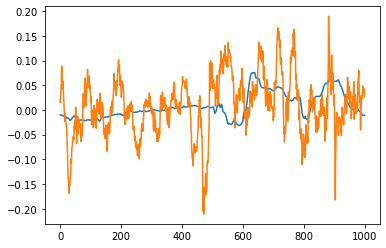

In [376]:
plt.plot(y_pred_ensemble)
plt.plot(y_test)

In [307]:
df_X = pd.DataFrame(val_predictions[0]).T

In [308]:
X = df_X.values
y = y_val.copy()

# scaler = StandardScaler()
# pca = PCA(n_components=5)

# X_train_transformed = scaler.fit_transform(X)
# X_train_transformed_pca = pca.fit_transform(X_train_transformed)
# Linear Regression model
regressor = sklearn.linear_model.Ridge()  
regressor.fit(X, y)

# X_test_transformed = scaler.transform(X_test)
# X_test_transformed_pca = pca.transform(X_test_transformed)

Ridge()

In [309]:
X_test_meta = pd.DataFrame(predictions[0]).T.values
y = y_test.copy()

In [310]:
# X_test_transformed = scaler.transform(X_test_meta)
# X_test_transformed_pca = pca.transform(X_test_transformed)
regressor.predict(X_test_meta)

array([0.0141646 , 0.0141696 , 0.01418171, ..., 0.01733184, 0.01715781,
       0.01702766], dtype=float32)

In [296]:
regressor.coef_

array([-0.02572451,  0.55883133, -0.02826423,  0.26528877, -0.05011677,
       -0.1117122 , -0.01522173,  0.03155287,  0.02030705,  0.5055765 ],
      dtype=float32)

In [311]:
eval_model(regressor.predict(X_test_meta),y_test)

(0.5874125874125874,
 0.0035962378745105672,
 -70.27144552255317,
 0.09522102523254722)

In [312]:
regressor.coef_

array([ 0.0128853 ,  0.02489848,  0.03054231, -0.00560454, -0.00121371,
        0.02749247,  0.05086502, -0.00147596,  0.0519386 , -0.01912808],
      dtype=float32)

In [ ]:
X_test_transformed = scaler.transform(X_test)
X_test_transformed_pca = pca.transform(X_test_transformed)

In [259]:
eval_model((df_test.max(axis=1)+df_test.min(axis=1))/2,y_test)

(0.5204795204795205,
 0.0041546263254227936,
 -6.648415331011898,
 -0.04044519610790699)

In [313]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')

ValueError: Found input variables with inconsistent numbers of samples: [477, 1001]

In [314]:
regressor.coef_

array([ 0.0128853 ,  0.02489848,  0.03054231, -0.00560454, -0.00121371,
        0.02749247,  0.05086502, -0.00147596,  0.0519386 , -0.01912808],
      dtype=float32)

In [315]:
val_count = regressor.coef_
coef = (val_count - val_count.min()) / (val_count - val_count.min()).sum()

In [316]:
regressor.coef_ = coef

In [317]:
regressor.coef_

array([0.08831748, 0.12145903, 0.13702907, 0.03730829, 0.04942157,
       0.12861526, 0.19309467, 0.04869811, 0.19605646, 0.        ],
      dtype=float32)

In [318]:
eval_model(regressor.predict(X_test_meta), y_test)

(0.5554445554445554,
 0.004575093805314486,
 -3.421861711894185,
 0.11751595663669939)

In [277]:
scores

array([-0.01013675, -0.00693025, -0.00405923, -0.00293456, -0.00237226])

In [274]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

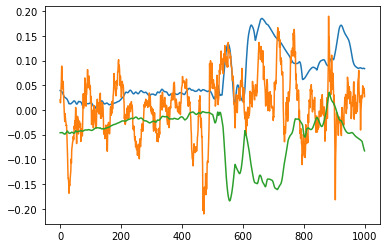

In [256]:
plt.plot(df_test.max(axis=1))

plt.plot(y_test)
plt.plot(df_test.min(axis=1))

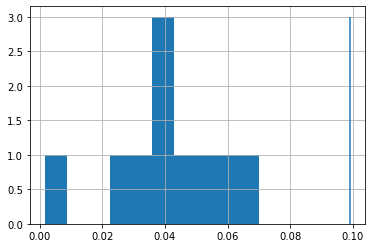

In [247]:
df_X.loc[10,:].hist()
plt.vlines(y_train[10],0,3)

In [210]:
df_test.values @ 

Exception: Dot product shape mismatch, (47,) vs (50, 1001)

0.010063692927360535

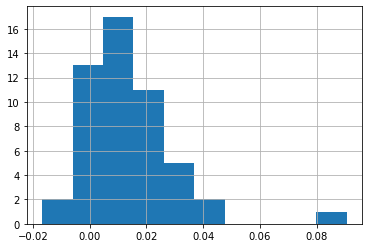

In [185]:
df_test.loc[9,:].hist()
df_test.loc[9,:].median()

In [202]:
plt.plot(df_test @ coef)

ValueError: matrices are not aligned

In [198]:
eval_model(df_test @ coef,y_test)

ValueError: matrices are not aligned

In [200]:
df_test[]

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,true_val
0,0.005665,0.006670,0.002392,-0.000891,-0.002041,-0.000647,0.042761,0.008830,0.026669,-0.000696,...,-0.003643,0.039381,0.008835,-0.003556,0.021408,0.020943,0.002698,0.033199,0.004584,0.056144
1,0.006238,0.005349,0.001298,-0.002608,-0.003611,-0.001947,0.040584,0.009880,0.026312,-0.001722,...,-0.003969,0.039419,0.008095,-0.004632,0.021019,0.021332,0.000705,0.032788,0.003843,0.055349
2,0.007008,0.004291,0.000551,-0.004218,-0.005094,-0.003074,0.038410,0.010775,0.026036,-0.002297,...,-0.004346,0.039764,0.007527,-0.005707,0.020742,0.021709,-0.001113,0.032530,0.003021,0.021330
3,0.007834,0.003711,0.000287,-0.005383,-0.006165,-0.003924,0.036650,0.011321,0.025938,-0.002241,...,-0.004641,0.040342,0.007249,-0.006507,0.020657,0.021957,-0.002310,0.032472,0.002275,0.009130
4,0.008519,0.003737,0.000617,-0.005763,-0.006513,-0.004285,0.035737,0.011233,0.026111,-0.001479,...,-0.004734,0.040949,0.007248,-0.006762,0.020798,0.021956,-0.002493,0.032592,0.001805,0.023821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,-0.012541,0.032153,-0.012520,-0.006927,0.005047,-0.039448,0.028240,-0.000697,0.027625,0.066166,...,-0.016900,0.015269,-0.002881,0.002511,0.005640,0.018578,0.004291,0.044922,-0.012459,0.051860
473,-0.012955,0.030820,-0.013380,-0.007219,0.004351,-0.039320,0.027536,-0.001530,0.027219,0.065601,...,-0.016980,0.014513,-0.003062,0.002110,0.004940,0.018077,0.003391,0.043351,-0.012923,0.061199
474,-0.013470,0.029649,-0.014246,-0.007389,0.003776,-0.039358,0.027029,-0.002318,0.026700,0.065004,...,-0.017003,0.013731,-0.003197,0.001690,0.004372,0.017368,0.002690,0.041746,-0.013354,0.047589
475,-0.014055,0.028493,-0.015129,-0.007476,0.003307,-0.039389,0.026651,-0.003156,0.026139,0.064291,...,-0.016992,0.012842,-0.003418,0.001272,0.003858,0.016536,0.002061,0.040028,-0.013715,0.018705


In [149]:
df_test = pd.DataFrame(val_predictions[0]).T
df_test['true_val'] = y_val
df_test

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,true_val
0,0.005665,0.006670,0.002392,-0.000891,-0.002041,-0.000647,0.042761,0.008830,0.026669,-0.000696,...,-0.003643,0.039381,0.008835,-0.003556,0.021408,0.020943,0.002698,0.033199,0.004584,0.056144
1,0.006238,0.005349,0.001298,-0.002608,-0.003611,-0.001947,0.040584,0.009880,0.026312,-0.001722,...,-0.003969,0.039419,0.008095,-0.004632,0.021019,0.021332,0.000705,0.032788,0.003843,0.055349
2,0.007008,0.004291,0.000551,-0.004218,-0.005094,-0.003074,0.038410,0.010775,0.026036,-0.002297,...,-0.004346,0.039764,0.007527,-0.005707,0.020742,0.021709,-0.001113,0.032530,0.003021,0.021330
3,0.007834,0.003711,0.000287,-0.005383,-0.006165,-0.003924,0.036650,0.011321,0.025938,-0.002241,...,-0.004641,0.040342,0.007249,-0.006507,0.020657,0.021957,-0.002310,0.032472,0.002275,0.009130
4,0.008519,0.003737,0.000617,-0.005763,-0.006513,-0.004285,0.035737,0.011233,0.026111,-0.001479,...,-0.004734,0.040949,0.007248,-0.006762,0.020798,0.021956,-0.002493,0.032592,0.001805,0.023821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,-0.012541,0.032153,-0.012520,-0.006927,0.005047,-0.039448,0.028240,-0.000697,0.027625,0.066166,...,-0.016900,0.015269,-0.002881,0.002511,0.005640,0.018578,0.004291,0.044922,-0.012459,0.051860
473,-0.012955,0.030820,-0.013380,-0.007219,0.004351,-0.039320,0.027536,-0.001530,0.027219,0.065601,...,-0.016980,0.014513,-0.003062,0.002110,0.004940,0.018077,0.003391,0.043351,-0.012923,0.061199
474,-0.013470,0.029649,-0.014246,-0.007389,0.003776,-0.039358,0.027029,-0.002318,0.026700,0.065004,...,-0.017003,0.013731,-0.003197,0.001690,0.004372,0.017368,0.002690,0.041746,-0.013354,0.047589
475,-0.014055,0.028493,-0.015129,-0.007476,0.003307,-0.039389,0.026651,-0.003156,0.026139,0.064291,...,-0.016992,0.012842,-0.003418,0.001272,0.003858,0.016536,0.002061,0.040028,-0.013715,0.018705


In [156]:
test = {}
for i in df_test.columns:
    if i == 'true_val':
        break
    test[i] = pearsonr(df_test[i], df_test['true_val'])

In [159]:
sorted(test.items(), key=lambda x: x[1], reverse=True)

[(23, (0.2862053020209985, 1.913718017263837e-10)),
 (30, (0.23452996888555083, 2.2045052767291211e-07)),
 (36, (0.22961099941988966, 3.988418637355707e-07)),
 (32, (0.2086049372450922, 4.333906523606518e-06)),
 (16, (0.19033822825218927, 2.8584828703360233e-05)),
 (42, (0.18746168476582395, 3.787668352702628e-05)),
 (26, (0.18596740820409247, 4.376740867164877e-05)),
 (6, (0.17561554331719714, 0.00011552094307270651)),
 (45, (0.1661769874337652, 0.00026716996597818475)),
 (34, (0.1515446432038236, 0.0008992172737226759)),
 (2, (0.14986238778360395, 0.0010270320082436933)),
 (46, (0.13771512075294967, 0.002576357077895164)),
 (8, (0.1362990179102923, 0.002854965032790074)),
 (13, (0.12826155602100603, 0.005023526876926627)),
 (15, (0.12577718343940045, 0.005946092049014147)),
 (11, (0.12478749133861382, 0.0063541449983031606)),
 (48, (0.11625367371122963, 0.011054294258545712)),
 (22, (0.11432571392286621, 0.01247000316410355)),
 (35, (0.1084808489223611, 0.017786195486360956)),
 (17, 

In [191]:
df_test_vote = {}
for i in df_test.columns:
    if i == 'true_val':
        break
    df_test_vote[i] = (df_test[i]- y_val) ** 2

In [192]:
df_test_vote = pd.DataFrame(df_test_vote)

In [193]:
df_test_vote['ColumnID']=df_test_vote.idxmin(axis=1)

In [194]:
val_count = df_test_vote['ColumnID'].value_counts().sort_index()

In [195]:
coef = (val_count - val_count.min()) / (val_count - val_count.min()).sum()

In [215]:
df_test_vote['ColumnID'].value_counts()

5     55
9     44
48    41
30    34
43    30
7     26
47    25
6     24
28    23
11    22
20    19
12    11
8     11
1      9
42     8
3      6
38     6
0      5
22     5
15     5
25     5
32     4
35     4
26     4
24     4
18     4
23     4
46     3
34     3
4      3
40     3
2      2
17     2
39     2
29     2
10     2
37     2
16     2
33     2
13     2
14     2
41     2
36     1
44     1
27     1
49     1
45     1
Name: ColumnID, dtype: int64

In [15]:
df_eval.groupby('seed').last()['accuracy'].median()

0.5574425574425574

In [16]:
name_all = ['nickel', 'tin']

name_assign = name_all * 100

df_eval['name'] = name_assign

for i,name in enumerate(name_all):
    y_pred_ensemble = np.mean(np.array(predictions[i]), axis=0)
    X_train, y_train, X_val, y_val, X_test, y_test = make_dataset(metal_group_2[i])
    acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    
    print(name, acc_ensemble, mse_ensemble, pcc_ensemble)
    

(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
nickel 0.5464535464535465 0.011736071232114443 0.05574208929645236
(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
tin 0.5894105894105894 0.004458012447299894 0.0333736111746791


In [19]:
res = []

for i in range(1001):
    model_pred = np.array(predictions[0])[:,i]
    upper_quantile = np.quantile(model_pred,0.85)
    lower_quantile = np.quantile(model_pred,0.15)

    robust_pred = model_pred[(model_pred < upper_quantile) & (model_pred > lower_quantile)]
    res.append(robust_pred.mean())

    
X_train, y_train, X_val, y_val, X_test, y_test = make_dataset(metal_group_2[0])
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(np.array(res),y_test)

print(name, acc_ensemble, mse_ensemble, pcc_ensemble)

(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
tin 0.5514485514485514 0.011685747152238773 0.06607813059748453


(2782, 66, 13) (2782,) (477, 66, 13) (477,) (1001, 66, 13) (1001,)
(0.5944055944055944, 0.002839090070072849, -6.452794396672657, 0.4825426082533175)


/home/yicheng.wang/miniconda3/envs/timeseries/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


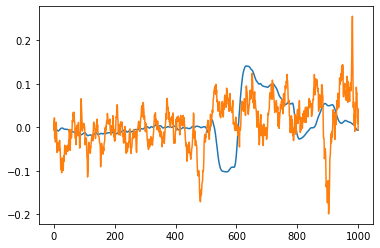

In [54]:
# meta learning
X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df = make_dataset(df_aluminium)

df_X = pd.DataFrame(X_predictions[0]).T     
df_X['y'] = y_train_df
df_y = pd.DataFrame(predictions[0]).T     

X = df_X.loc[:,  (df_X.columns != 'y')].values
y = df_X.loc[:,  (df_X.columns == 'y')].values

# regressor = Lasso(alpha=0.0001,precompute=True,max_iter=100000,
#             positive=True)
# regressor.fit(X, y)

regressor = SVR(C=0.1, gamma=0.01,kernel='rbf')
regressor.fit(X, y)

meta_res = regressor.predict(df_y.values)
print(eval_model(meta_res, y_test_df.flatten()))
plt.plot(y_pred_ensemble)
plt.plot(y_test_df.flatten())

In [2]:
df_X

NameError: name 'df_X' is not defined

In [60]:
best_mse = 1e9

for i in range(100):
    mse = mean_squared_error(df_X[i], df_X['y'])
    if mse <= best_mse:
         

0.0046363042778265326

In [30]:
import os

In [43]:
import pickle
with open('/home/yicheng.wang/UCL-Dissertation/models/LSTM-mse-multi-metal1-128units/multi-metal1-ypred.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [56]:
data['seed_0'].shape

(50,)

In [60]:
dataset_all = [df_palladium, df_platinum, df_rhodium]
name_all = ['palladium', 'platinum', 'rhodium']

In [62]:
for i,name in enumerate(name_all):
    y_pred_ensemble = np.mean(np.array(data['seed_{}'.format(i)]), axis=0)
    X_train, y_train, X_val, y_val, X_test, y_test = make_dataset(dataset_all[i])
    acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)
    
    print(name, acc_ensemble, mse_ensemble, pcc_ensemble)
    

(2782, 66, 12) (2782,) (477, 66, 12) (477,) (1001, 66, 12) (1001,)
palladium 0.5684315684315684 0.014853517708832897 -0.061701228188037735
(2782, 66, 12) (2782,) (477, 66, 12) (477,) (1001, 66, 12) (1001,)
platinum 0.5114885114885115 0.00801055035979046 0.013749159906961362
(2782, 66, 12) (2782,) (477, 66, 12) (477,) (1001, 66, 12) (1001,)
rhodium 0.6583416583416584 0.030380381081700707 -0.011673907601263335


(2782, 66, 12) (2782,) (477, 66, 12) (477,) (1001, 66, 12) (1001,)
(0.5544455544455544, 0.0048142202353002985, -0.8270474609250666, 0.2263263254506896)


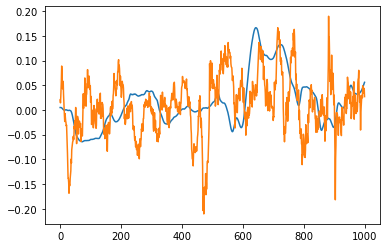

In [82]:
# meta learning
X_train_df, y_train_df, _, _, X_test_df, y_test_df = make_dataset(df_copper)

df_X = pd.DataFrame(X_predictions[0]).T     
df_X['y'] = y_train_df
df_y = pd.DataFrame(predictions[0]).T     

X = df_X.loc[:,  (df_X.columns != 'y')].values
y = df_X.loc[:,  (df_X.columns == 'y')].values

regressor = Lasso(alpha=0.0001,precompute=True,max_iter=100000,
            positive=True)
regressor.fit(X, y)

# regressor = SVR(C=0.1, gamma=0.1,kernel='rbf')
# regressor.fit(X, y)

meta_res = regressor.predict(df_y.values)
print(eval_model(meta_res, y_test_df.flatten()))
plt.plot(meta_res)
plt.plot(y_test_df.flatten())

In [65]:
regressor.coef_

AttributeError: coef_ is only available when using a linear kernel

In [186]:
df_ypred = pd.DataFrame.from_dict(predictions, orient='index').transpose()

In [194]:
df_ypred = df_ypred.add_prefix('seed_')

In [203]:
df_ypred.to_pickle('pickle-test.pkl')

In [11]:
df_t = pd.read_pickle('/home/yicheng.wang/UCL-Dissertation/models/LSTM-mse-multi-metal1-128units/multi-metal1-Xpred.pkl')
df_t['seed_0'][0][0]

0.091735

In [13]:
df_t['seed_0']

0     [0.091735, 0.09101739, 0.0902674, 0.08952653, ...
1     [0.060457863, 0.06023736, 0.060151998, 0.06005...
2     [0.055102978, 0.053989854, 0.0526977, 0.051212...
3     [0.07942314, 0.07938149, 0.07936091, 0.0793010...
4     [0.078874126, 0.07876377, 0.078707874, 0.07862...
5     [0.056873776, 0.057470694, 0.058244653, 0.0592...
6     [0.06395463, 0.06468053, 0.0656466, 0.06675474...
7     [0.09392369, 0.093847744, 0.09371409, 0.093456...
8     [0.07317445, 0.07288564, 0.07268297, 0.0725525...
9     [0.04390703, 0.044569224, 0.04536427, 0.046181...
10    [0.08721266, 0.08610486, 0.08478638, 0.083246,...
11    [0.050136887, 0.05094195, 0.051879533, 0.05280...
12    [0.076991245, 0.07737049, 0.078025274, 0.07881...
13    [0.06347537, 0.06285971, 0.062291246, 0.061642...
14    [0.052691415, 0.052578215, 0.05249553, 0.05237...
15    [0.093607314, 0.0934244, 0.09314968, 0.0928262...
16    [0.045153663, 0.04529968, 0.04573046, 0.046381...
17    [0.078739725, 0.07842629, 0.078091465, 0.0

In [185]:
X_train_df, y_train_df, _, _, X_test_df, y_test_df = make_dataset(df)

df_X = pd.DataFrame(X_predictions[0]).T     
df_X['y'] = y_train_df
df_y = pd.DataFrame(predictions[0]).T     

X = df_X.loc[:,  (df_X.columns != 'y')].values
y = df_X.loc[:,  (df_X.columns == 'y')].values

# regressor = LinearRegression(positive=True)
# regressor.fit(X, y)

regressor = SVR(C=0.1, gamma=0.1,kernel='rbf')
regressor.fit(X, y)

meta_res = regressor.predict(df_y.values)

acc_meta, mse_meta, r_square_meta, pcc_meta = eval_model(meta_res.flatten(), y_test_df)
# df_metric.loc[len(df_metric.index)] = ['meta_result', acc_meta, mse_meta, r_square_meta, pcc_meta]
acc_meta, mse_meta, r_square_meta, pcc_meta

(2782, 66, 12) (2782,) (477, 66, 12) (477,) (1001, 66, 12) (1001,)


c:\Users\wyic6\anaconda3\envs\timeseries\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.6143856143856143,
 0.004296900582683222,
 -8.547828035322967,
 0.09693798270372303)

In [174]:
df_y

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.018715,-0.005410,-0.022631,0.003104,0.000744,-0.038454,-0.002792,0.001511,0.010605,0.017164,...,-0.023790,0.007699,0.010629,-0.000751,-0.014184,0.003654,0.006830,-0.005293,0.008007,0.003427
1,-0.018778,-0.005511,-0.022788,0.003079,0.000561,-0.038650,-0.002865,0.001490,0.010535,0.017079,...,-0.023750,0.007771,0.010500,-0.000816,-0.014276,0.003467,0.006780,-0.005411,0.008011,0.003359
2,-0.018912,-0.005652,-0.022968,0.003039,0.000412,-0.038854,-0.002952,0.001409,0.010496,0.016916,...,-0.023712,0.007865,0.010304,-0.000939,-0.014400,0.003289,0.006719,-0.005536,0.008040,0.003308
3,-0.019119,-0.005829,-0.023180,0.002976,0.000290,-0.039049,-0.003075,0.001259,0.010495,0.016665,...,-0.023676,0.007961,0.010036,-0.001120,-0.014556,0.003134,0.006651,-0.005685,0.008076,0.003253
4,-0.019375,-0.006011,-0.023420,0.002889,0.000166,-0.039246,-0.003255,0.001078,0.010517,0.016336,...,-0.023657,0.008033,0.009730,-0.001327,-0.014733,0.003017,0.006591,-0.005862,0.008112,0.003185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.093341,0.032531,0.030152,-0.040896,-0.115660,0.041752,0.039552,0.088168,-0.062899,0.051830,...,-0.017369,0.035805,0.012799,-0.021485,0.008553,-0.115564,0.039533,0.021194,-0.018754,0.021582
997,0.094094,0.032113,0.030389,-0.041480,-0.116819,0.040986,0.039578,0.089195,-0.064936,0.052401,...,-0.017618,0.035821,0.012550,-0.022096,0.007941,-0.117591,0.040142,0.021453,-0.018830,0.021843
998,0.094769,0.031660,0.030535,-0.042159,-0.118002,0.040332,0.039500,0.090072,-0.066848,0.052774,...,-0.017902,0.035816,0.012196,-0.022673,0.007321,-0.119443,0.040694,0.021592,-0.018925,0.022079
999,0.095412,0.031183,0.030617,-0.042909,-0.119205,0.039770,0.039341,0.090843,-0.068626,0.052999,...,-0.018226,0.035811,0.011813,-0.023232,0.006707,-0.121189,0.041211,0.021669,-0.018969,0.022280


In [134]:
y_pred_ensemble = np.mean(np.array(predictions[0]), axis=0)
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)

In [141]:
eval_model(predictions[0][0],y_test)

(0.4725274725274725,
 0.006805916187514737,
 -1.8051243474349064,
 -0.024969540507185882)

In [135]:
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble 

(0.5904095904095904,
 0.003903481546263919,
 -11.189124982876598,
 0.23000083564140214)

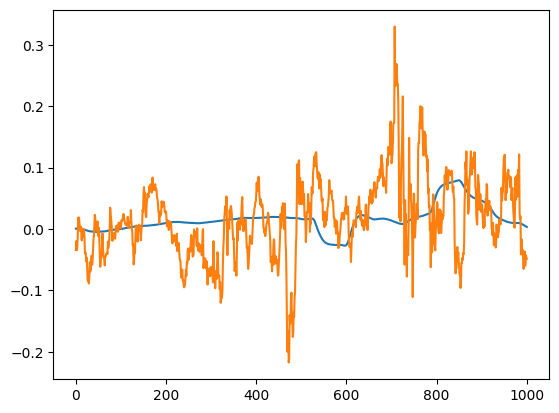

In [181]:
plt.plot(meta_res)
plt.plot(y_test)

In [117]:
df_xpred = pd.DataFrame.from_dict(X_predictions, orient='index').transpose()
df_xpred = df_xpred.add_prefix('seed_')
df.to_csv(output_model_dir + "{}".format(),index=False)

,col_0,col_1,col_2
0,"[0.008183799, 0.007816336, 0.007491007, 0.0072...",None,None
1,"[0.014324768, 0.014284077, 0.014294216, 0.0143...",None,None
2,"[0.031654343, 0.031896114, 0.032117423, 0.0323...",None,None
3,"[0.00012141692, -0.00017669753, -0.0006098469,...",None,None
4,"[0.0034075833, 0.003056118, 0.0028082093, 0.00...",None,None
...,...,...,...
95,"[0.018939517, 0.018739324, 0.018409709, 0.0179...",None,None
96,"[0.016034877, 0.01610157, 0.01611253, 0.016108...",None,None
97,"[0.017428748, 0.017441552, 0.017469855, 0.0175...",None,None
98,"[-0.00035363683, -0.001018087, -0.0015600888, ...",None,None


In [118]:
df_xpred

,0,1,2
0,"[0.008183799, 0.007816336, 0.007491007, 0.0072...",None,None
1,"[0.014324768, 0.014284077, 0.014294216, 0.0143...",None,None
2,"[0.031654343, 0.031896114, 0.032117423, 0.0323...",None,None
3,"[0.00012141692, -0.00017669753, -0.0006098469,...",None,None
4,"[0.0034075833, 0.003056118, 0.0028082093, 0.00...",None,None
...,...,...,...
95,"[0.018939517, 0.018739324, 0.018409709, 0.0179...",None,None
96,"[0.016034877, 0.01610157, 0.01611253, 0.016108...",None,None
97,"[0.017428748, 0.017441552, 0.017469855, 0.0175...",None,None
98,"[-0.00035363683, -0.001018087, -0.0015600888, ...",None,None


In [29]:
predictions, X_predictions, eval_metrics = backtestLSTM(X_train_concat, y_train_concat, X_val_concat, y_val_concat, X_test, y_test, num_layers=3, units_per_layer=[128,128,128], has_dropout=True, dropout_size=0.2)

experiment seed:  0
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 10ms/step
experiment seed:  1
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 8ms/step
experiment seed:  2
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 8ms/step
experiment seed:  3
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 9ms/step
experiment seed:  4
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 8ms/step
experiment seed:  5
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 8ms/step
experiment seed:  6
(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)
87/87 [==============================] - 1s 8ms/step
experiment seed:  7

In [31]:
df_eval = pd.DataFrame(eval_metrics)

In [38]:
predictions

{0: [array([0.0081838 , 0.00781634, 0.00749101, ..., 0.01870517, 0.01922117,
         0.01973658], dtype=float32),
  array([0.01432477, 0.01428408, 0.01429422, ..., 0.03565798, 0.0357336 ,
         0.03619414], dtype=float32),
  array([ 0.03165434,  0.03189611,  0.03211742, ..., -0.01942255,
         -0.0193532 , -0.01937849], dtype=float32),
  array([ 0.00012142, -0.0001767 , -0.00060985, ...,  0.02195313,
          0.02141159,  0.0206579 ], dtype=float32),
  array([0.00340758, 0.00305612, 0.00280821, ..., 0.03129294, 0.03118269,
         0.03068606], dtype=float32),
  array([0.00018502, 0.00031602, 0.00055253, ..., 0.05424522, 0.05525532,
         0.05633451], dtype=float32),
  array([0.00934887, 0.00827351, 0.00735904, ..., 0.02873584, 0.02941242,
         0.02961526], dtype=float32),
  array([0.00306694, 0.00310672, 0.00329901, ..., 0.02150117, 0.02263971,
         0.02465359], dtype=float32),
  array([0.03307946, 0.03262104, 0.03224023, ..., 0.04131712, 0.04165957,
         0.0424

In [39]:
y_pred_ensemble = np.mean(np.array(predictions[0]), axis=0)
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble  = eval_model(y_pred_ensemble,y_test)

In [40]:
acc_ensemble, mse_ensemble, r_square_ensemble, pcc_ensemble

(0.6333666333666333,
 0.0025217859847037386,
 -8.293093533810834,
 0.4226825840685079)

In [42]:
df_eval['accuracy'].median()

0.6198801198801198

In [87]:
X_train_df, y_train_df, _, _, X_test_df, y_test_df = make_dataset(df_aluminium)

df_X = pd.DataFrame(X_predictions[0]).T     
df_X['y'] = y_train_df
df_y = pd.DataFrame(predictions[0]).T     

X = df_X.loc[:,  (df_X.columns != 'y')].values
y = df_X.loc[:,  (df_X.columns == 'y')].values

regressor = Lasso(alpha=0.00001,precompute=True,max_iter=100000,
            positive=True)
regressor.fit(X, y)

# regressor = SVR(C=1, gamma=0.1,kernel='linear')
# regressor.fit(X, y)

svm_res = regressor.predict(df_y.values)

eval_model(svm_res, y_test_df)

(0.6823176823176823,
 0.0026815493841015805,
 -0.8422191617890471,
 0.44166308494411943)

In [89]:
eval_model(df_y.values@regressor.coef_ + regressor.intercept_ , y_test_df)

(0.6823176823176823,
 0.0026815493841015805,
 -0.8422191617890471,
 0.44166308494411943)

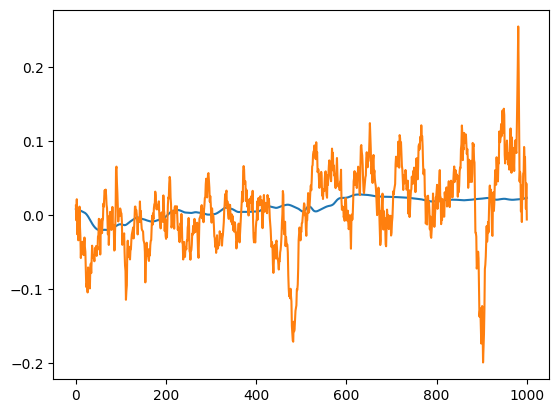

In [68]:
plt.plot(svm_res)
plt.plot(y_test_df)

In [319]:
df_metric = pd.DataFrame(eval_metrics)

<AxesSubplot:>

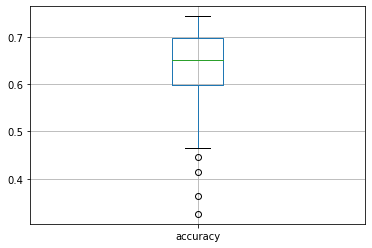

In [320]:
df_metric.groupby('seed').first().boxplot(['accuracy'])

In [321]:
predictions

{0: [array([0.00418515, 0.00407025, 0.00398293, ..., 0.01421934, 0.0144037 ,
         0.0145416 ], dtype=float32),
  array([0.01229765, 0.01250381, 0.01274112, ..., 0.00324706, 0.00349328,
         0.00398691], dtype=float32),
  array([0.02083925, 0.02078603, 0.02079257, ..., 0.01424442, 0.01446405,
         0.01471805], dtype=float32),
  array([0.01662198, 0.01639609, 0.01604151, ..., 0.0267175 , 0.02614554,
         0.0254128 ], dtype=float32),
  array([-0.00473484, -0.00523057, -0.00567028, ...,  0.01569452,
          0.01509162,  0.01384123], dtype=float32),
  array([-0.01161885, -0.011692  , -0.01165998, ...,  0.03098192,
          0.03207559,  0.03318716], dtype=float32),
  array([0.00557167, 0.00522423, 0.00507381, ..., 0.02085298, 0.02110015,
         0.02119061], dtype=float32),
  array([0.01764404, 0.01757458, 0.01772388, ..., 0.00476113, 0.00614712,
         0.00864385], dtype=float32),
  array([0.03369237, 0.03308382, 0.03254849, ..., 0.01150983, 0.01194159,
         0.0128

In [322]:
_, _, _, _, X_test, y_test = make_dataset(df_aluminium)
y_pred_ensemble = np.mean(np.array(predictions[0]), axis=0)
eval_model(y_pred_ensemble,y_test)

(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)


(0.6833166833166833,
 0.0024451454066019176,
 -8.037252893693596,
 0.4336206202707146)

In [323]:
_, _, _, _, X_test, y_test = make_dataset(df_copper)
y_pred_ensemble = np.mean(np.array(predictions[1]), axis=0)
eval_model(y_pred_ensemble,y_test)

(2782, 66, 18) (2782,) (477, 66, 18) (477,) (1001, 66, 18) (1001,)


(0.5464535464535465,
 0.003566685453262951,
 -4.998558084769271,
 0.18416037153624176)

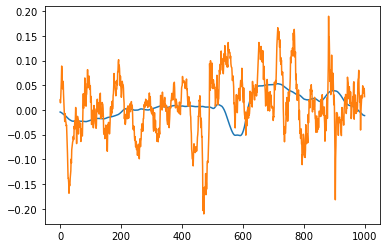

In [88]:
plt.plot(y_pred_ensemble)
plt.plot(y_test)